Importamos las librerías necesarias

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cornac
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, Precision, MAE, RMSE
from sklearn.neighbors import NearestNeighbors
from cornac.models import Recommender
from surprise import SVD
from cornac.eval_methods import RatioSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

Crear un modelo propio

In [10]:
class MeanRecommender(Recommender):
    def __init__(self, name="MeanRecommender"):
        super().__init__(name=name)
        self.item_means = None

    def fit(self, train_set, val_set):
        super().fit(train_set, val_set)
        # Calcular la media de las calificaciones para cada ítem
        self.item_means = np.zeros(train_set.num_items)
        for i in range(train_set.num_items):
            ratings = train_set.matrix[:, i].data
            if len(ratings) > 0:
                self.item_means[i] = np.mean(ratings)
            else:
                self.item_means[i] = 0

    def score(self, user_id, item_id=None):
        if item_id is None:
            return self.item_means
        return self.item_means[item_id]

class LSARecommender(Recommender):
    def __init__(self, data, n_components=50, name="LSARecommender"):
        super().__init__(name=name)
        self.n_components = n_components
        self.data = data

    def fit(self, train_set, val_set):
        super().fit(train_set, val_set)
        # Obtener las interacciones usuario-item
        interactions = train_set.matrix

        # Aplicar TF-IDF
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(interactions.toarray().astype(str))

        # Aplicar LSA (SVD truncado)
        lsa = TruncatedSVD(n_components=self.n_components)
        self.X_lsa = lsa.fit_transform(X)

        # Calcular similitud de coseno
        self.similarity_matrix = cosine_similarity(self.X_lsa)

    def score(self, user_idx, item_idx=None):
        if item_idx is None:
            # Calcular las puntuaciones para todos los ítems
            scores = self.similarity_matrix[user_idx]
            return scores
        else:
            # Calcular la puntuación para un ítem específico
            score = self.similarity_matrix[user_idx, item_idx]
            return score

    def recommend(self, user_idx, top_n=5):
        similar_indices = self.similarity_matrix[user_idx].argsort()[:-top_n-1:-1]
        similar_indices = similar_indices[1:]  # Excluir el usuario mismo
        return similar_indices



Cargar el dataset de MovieLens 100K

In [11]:
data = movielens.load_feedback()
dato = movielens.load_plot()

Definir el método de evaluación

In [12]:
ratio_split = RatioSplit(data=data, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)
ratio_split2 = RatioSplit(data=data, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)


rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1657
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1657
Number of ratings = 19968
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1657
rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1645
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1645
Number of ratings = 19954
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1645


Definir los modelos a emplear

In [13]:
mean_recommender = MeanRecommender() # Modelo propio
lsa = LSARecommender(data=data)
mf = cornac.models.MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
bpr = cornac.models.BPR(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
wmf = cornac.models.WMF()
svd = cornac.models.SVD()
knn = NearestNeighbors(n_neighbors=5, metric='cosine') # Crear el modelo KNN



Definir las metricas a utilizar

In [14]:
metrics = []
metrics.append(MAE())
metrics.append(RMSE())
metrics.append(Recall(10))
metrics.append(Precision(10))

Definir el experimento con el modelo propio


In [15]:
experiment = cornac.Experiment(eval_method=ratio_split, models=[mean_recommender, mf, bpr, svd], metrics=metrics)
# experiment2 = cornac.Experiment(eval_method=ratio_split, models=[lsa], metrics=metrics)

Ejecutar el experimento

In [16]:
experiment.run()
# experiment2.run()


[MeanRecommender] Training started!

[MeanRecommender] Evaluation started!


Rating:   0%|          | 0/19968 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/19968 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/19968 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


[SVD] Training started!

[SVD] Evaluation started!


Rating:   0%|          | 0/19968 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


TEST:
...
                |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
--------------- + ------ + ------ + ------------ + --------- + --------- + --------
MeanRecommender | 0.8333 | 0.9926 |       0.0002 |    0.0002 |    0.8692 |   3.0322
MF              | 0.7473 | 0.9033 |       0.0743 |    0.0538 |    0.8530 |   7.9777
BPR             | 2.1488 | 2.3479 |       0.1105 |    0.1117 |    0.3035 |   7.2720
SVD             | 0.7567 | 0.9132 |       0.0584 |    0.0434 |    0.1074 |   4.6431



Extraer los resultados de las métricas

In [17]:
results = experiment.result
mf_mae = results[0].metric_avg_results['MAE']
mf_rmse = results[0].metric_avg_results['RMSE']
bpr_mae = results[1].metric_avg_results['MAE']
bpr_rmse = results[1].metric_avg_results['RMSE']
wmf_mae = results[2].metric_avg_results['MAE']
wmf_rmse = results[2].metric_avg_results['RMSE']
svd_mae = results[3].metric_avg_results['MAE']
svd_rmse = results[3].metric_avg_results['RMSE']
svd_precision = results[3].metric_avg_results['Precision@10']

Crear un gráfico de barras para mostrar los resultados

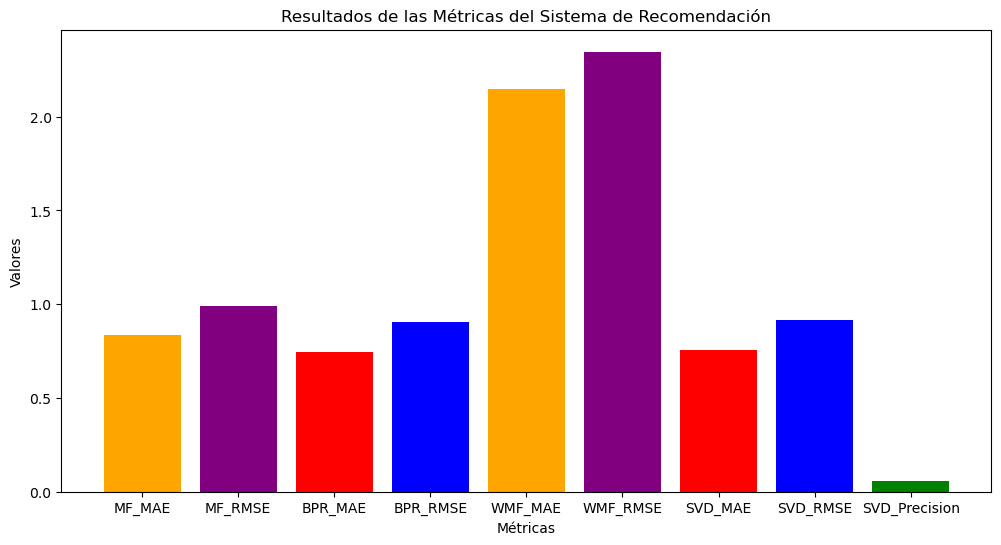

In [18]:
metrics_names = ['MF_MAE', 'MF_RMSE', 'BPR_MAE', 'BPR_RMSE', 'WMF_MAE', 'WMF_RMSE', 'SVD_MAE', 'SVD_RMSE', 'SVD_Precision']
values = [mf_mae, mf_rmse, bpr_mae, bpr_rmse, wmf_mae, wmf_rmse, svd_mae, svd_rmse, svd_precision]

plt.figure(figsize=(12, 6))
plt.bar(metrics_names, values, color=['orange', 'purple', 'red', 'blue', 'orange', 'purple', 'red', 'blue', 'green'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados de las Métricas del Sistema de Recomendación')
plt.show()
